In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import torch
import quairkit as qkit
from quairkit import to_state, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qsp import *
from qite import *

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
revise_tol(1e-40)

qkit.set_dtype('complex128')

# qkit.set_seed(np.random.randint(1e7))
qkit.set_seed(3148447)
qkit.get_seed()

3148447

## Hamiltonian

In [4]:
def hamiltonian_heisenberg(n=6, hz=1, hx=0, hy=0, hzz=1, hxx=1, hyy=1):
    pauli_terms = []

    # Single-qubit terms
    for i in range(n):
        if hx != 0:
            pauli_terms.append([hx, f'X{i}'])
        if hy != 0:
            pauli_terms.append([hy, f'Y{i}'])
        if hz != 0:
            pauli_terms.append([hz, f'Z{i}'])

    # Two-qubit terms (OBC)
    for i in range(n - 1):
        if hxx != 0:
            pauli_terms.append([hxx, f'X{i}, X{i + 1}'])
        if hyy != 0:
            pauli_terms.append([hyy, f'Y{i}, Y{i + 1}'])
        if hzz != 0:
            pauli_terms.append([hzz, f'Z{i}, Z{i + 1}'])

    return Hamiltonian(pauli_terms)

In [5]:
qb_num = 4

H_init = hamiltonian_heisenberg(n=qb_num, hx=-0.5, hz=0, hxx=-1, hyy=-1, hzz=-1)

max_abs_eigen = (torch.linalg.eigvalsh(H_init.matrix)).abs().max() * 1.5
new_pauli_string = [[coef / max_abs_eigen, pauli_str]
                    for coef, pauli_str in H_init.pauli_str]
H = Hamiltonian(new_pauli_string)

phi = zero_state(qb_num)

In [6]:
eigenvalues, eigenvectors = torch.linalg.eigh(H.matrix)

min_eigen = eigenvalues.real.min()
min_index = torch.argmin(min_eigen)

min_eigenvector = eigenvectors[:, min_index]

print(f'ground state energy = {min_eigen}')

min_eigenvector_state = to_state(min_eigenvector)

gamma = phi.bra @ min_eigenvector_state.ket
print(f'gamma = {gamma.item()}')

ground state energy = -0.5156684612641719
gamma = (-0.25000000000000067+0j)


In [7]:
P = nkron(zero_state(1).bra, eye(2 ** (qb_num)))

pauli_sum = np.abs(H.coefficients).sum()

## Figure 1

In [8]:
# Assume H.matrix is a d x d matrix, so eigenvectors is a d x d matrix with columns as eigenvectors
# Extract the first eigenvector (ground state)
psi0 = eigenvectors[:, 0]  # Shape: (d,)

# Extract all remaining eigenvectors and take their sum
psi_rest_sum = eigenvectors[:, 1:].sum(dim=1)  # Shape: (d,)

# Calculate normalization coefficients
n_states = eigenvectors.shape[0]  # i.e., d = 2^n
coeff0 = 1.0 / torch.sqrt(torch.tensor(2.0, device=psi0.device, dtype=psi0.dtype))
coeff_rest = 1.0 / torch.sqrt(torch.tensor(2 * (n_states - 1), dtype=psi0.dtype, device=psi0.device))

# Construct the superposed state
superposed_state = coeff0 * psi0 + coeff_rest * psi_rest_sum
psi = to_state(superposed_state)

gamma_psi = psi.bra @ min_eigenvector_state.ket
print(f'gamma = {gamma_psi}')

gamma = tensor([[0.7071+0.j]])


In [9]:
only_P = False
tau = 20
deg = max(50, even_floor(0.056 * (tau**3) -4.47 * (tau**2) + 121.36 * tau - 800))
List_lambda_test = np.linspace(-min_eigen - 0.2, -min_eigen + 1/tau + 0.1, 100)
U_ideal = torch.matrix_exp(- tau * H.matrix)
ideal_state = U_ideal @ psi.ket
ideal_state = ideal_state / torch.linalg.norm(ideal_state)
ideal_state = to_state(ideal_state)

List_fidelity = []
List_probability = []

for lambda_0 in List_lambda_test:
    list_theta, list_phi = qite.get_qpp_angle(guess_lambda=lambda_0, tau=tau, deg=deg, only_P=only_P, learn=False)
    num_qubits = H.n_qubits
    H_matrix = H.matrix
    input_state = nkron(zero_state(1), psi)

    U = torch.matrix_exp(-1j * H_matrix)
    cir = qpp_cir(list_theta, list_phi, U)
    output_state = cir(input_state).ket
    output_state = P @ output_state
    List_probability.append(torch.linalg.norm(output_state)**2)
    output_state = output_state / torch.linalg.norm(output_state)

    List_fidelity.append(state_fidelity(ideal_state, to_state(output_state)))

In [10]:
projection_bound_psi = 0.85**2 * np.exp(-2) * np.abs(gamma_psi)**2

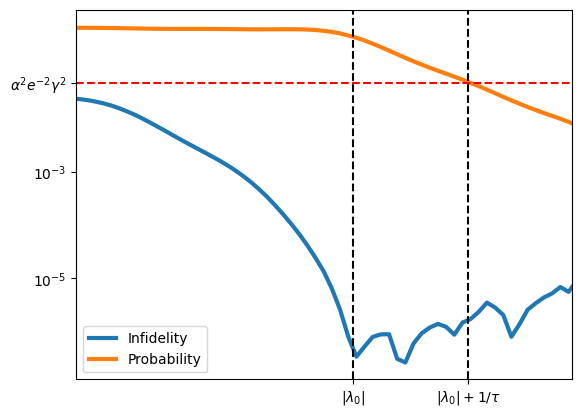

In [11]:
plt.plot(List_lambda_test, np.log10(1- np.array(List_fidelity)), label='Infidelity', color='C0', lw=3)


plt.plot(List_lambda_test, np.log10(List_probability), label='Probability', color='C1', lw=3)


plt.axvline(x=-min_eigen, color='black', linestyle='--')
plt.axvline(x=-min_eigen + 1 / tau, color='black', linestyle='--')

plt.axhline(y=np.log10(projection_bound_psi), color='red', linestyle='--')


plt.xticks([-min_eigen, -min_eigen + 1 / tau], ['$|\lambda_0|$', '$|\lambda_0| + 1 / \\tau$'])
plt.yticks([np.log10(projection_bound_psi.item()), -3, -5], ['$\\alpha^2e^{-2}\gamma^2$', '$10^{-3}$', '$10^{-5}$'])

plt.xlim([-min_eigen - 0.12, -min_eigen + 1/tau + 0.045])
plt.legend(loc='lower left')

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family
plt.rcParams["font.size"] = 20

plt.show()

## Figure 2

In [12]:
List_tau = list(np.arange(50, 9, -2.5))

List_project_to_zero_state = []

List_E_tau_real = []

only_P = False
learn = False

for tau in List_tau:
    deg = max(50, even_floor(0.056 * (tau**3) -4.47 * (tau**2) + 121.36 * tau - 500))
    if tau < 20:
        def b_tau_inv(x):
            return max(1e-5, 1 / (10 * x ** 2))
    elif tau >= 20:
        def b_tau_inv(x):
            return max(1e-5, 1 / (1 * x ** 2))
    b_tau = b_tau_inv(tau)

    lambda_0 = -np.array(min_eigen) + 1 / tau

    list_theta, list_phi = qite.get_qpp_angle(guess_lambda=lambda_0, tau=tau, deg=deg, only_P=only_P)
    num_qubits = H.n_qubits
    H_matrix = H.matrix
    input_state = nkron(zero_state(1), phi)

    U = torch.matrix_exp(-1j * H_matrix)
    cir = qpp_cir(list_theta, list_phi, U)
    output_state = cir(input_state).ket
    output_state = P @ output_state
    List_project_to_zero_state.append(torch.linalg.norm(output_state)**2)
    output_state = output_state / torch.linalg.norm(output_state)

    output_state = to_state(output_state)
    List_E_tau_real.append((output_state.bra @ H.matrix @ output_state.ket).real.item())


In [13]:
projection_bound = 0.85**2 * np.exp(-2) * np.abs(gamma)**2

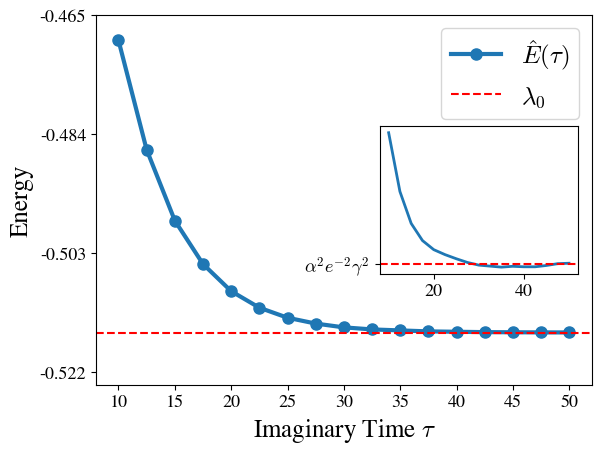

In [14]:
# Font size for labels and titles
fontsize = 18

# Plot the energy vs imaginary time
plt.plot(List_tau, List_E_tau_real, 'o-', label=r'$\hat{E}(\tau)$', linewidth=3, markersize=8)

# Draw a horizontal line at the minimum eigenvalue (ground state energy)
plt.axhline(y=min_eigen, color='r', linestyle='--', label=r'$\lambda_0$')

# Set axis labels
plt.xlabel(r'Imaginary Time $\tau$', fontsize=fontsize)
plt.ylabel('Energy', fontsize=fontsize)

# Add legend to the main plot
plt.legend(loc='upper right', fontsize=fontsize)

# Define custom y-ticks for better readability
yticks0 = np.linspace(-0.465, -0.522, 4)
plt.yticks(yticks0, [f'{tick:.3f}' for tick in yticks0])
plt.tick_params(labelsize=13)  # Increase tick label size

# Fix lower y-limit for consistency
plt.ylim(-0.524, None)

# Create an inset axes for projection to zero state
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='center right')

# Plot the projection to the zero state over imaginary time
ax_inset.plot(List_tau, List_project_to_zero_state, '-', linewidth=2)

# Draw a horizontal line indicating the theoretical bound
ax_inset.axhline(y=projection_bound.real, color='r', linestyle='--')

# Set y-ticks for the inset plot
# Ensure that projection_bound is a scalar value
ax_inset.set_yticks([projection_bound.real.item()])
ax_inset.set_yticklabels([r'$\alpha^2 e^{-2} \gamma^2$'])

# Adjust font size of tick labels in the inset
ax_inset.tick_params(labelsize=13)

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

# Display the final figure
plt.show()

## Ground State Energy Estimation

In [15]:
phi = zero_state(qb_num)

In [16]:
tau = 20
deg = max(50, even_floor(0.056 * (tau**3) -4.47 * (tau**2) + 121.36 * tau - 500))

learn = False
only_P = False
b_tau = max(1e-5, 1 / (1 * tau ** 2))
lambda_binary = ground_energy_eva.binary_search(tau=tau, H=H, phi=phi, deg=deg, b_tau=b_tau, only_P=only_P, learn=learn)

delta_tau = 2.5

 # Initialize parameters
delta = lambda_binary / 3

List_E_tau = []
List_ground_tau = []
List_error = []
List_resource = []

List_ground_tau, List_E_tau, List_error, List_resource = algorithm1(tau=tau, H=H, phi=phi, lambda_0=lambda_binary, deg=deg,
                                                                        b_tau=b_tau, only_P=only_P, learn=learn, delta_tau=delta_tau)


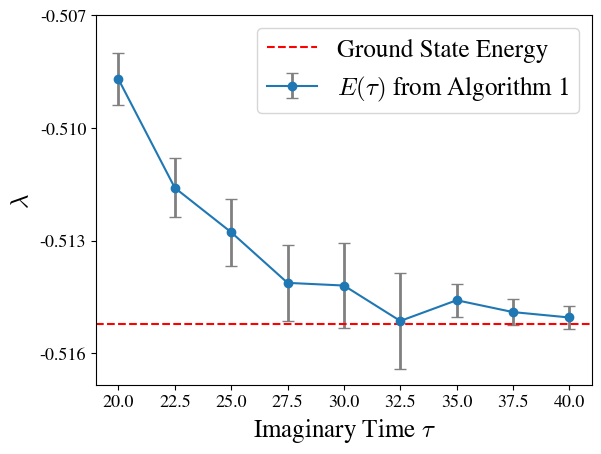

In [17]:
plt.errorbar(List_ground_tau, List_E_tau, yerr=List_error, fmt='o-', color='C0', ecolor='grey', elinewidth=2, capsize=4, label=r'$E(\tau)$ from Algorithm 1')
plt.axhline(y=min_eigen, color='r', linestyle='--', label='Ground State Energy')
plt.xlabel('Imaginary Time $\\tau$', fontsize=fontsize)
plt.ylabel('$\\lambda$', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)
yticks1 = np.linspace(-0.507, -0.5165, 4)
plt.yticks(yticks1, [f'{tick:.3f}' for tick in yticks1])

plt.tick_params(labelsize=13)

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

plt.show()

In [18]:
List_E_tau_log = np.log10(np.abs(np.array(List_E_tau) - min_eigen.item()))

In [19]:
# 1. linear fit: y = a * x + b
coeffs = np.polyfit(List_resource, List_E_tau_log, 1)
poly_func = np.poly1d(coeffs)

# 2. generate x and y values
x_fit = np.linspace(min(List_resource), max(List_resource), 100)
y_fit = poly_func(x_fit)

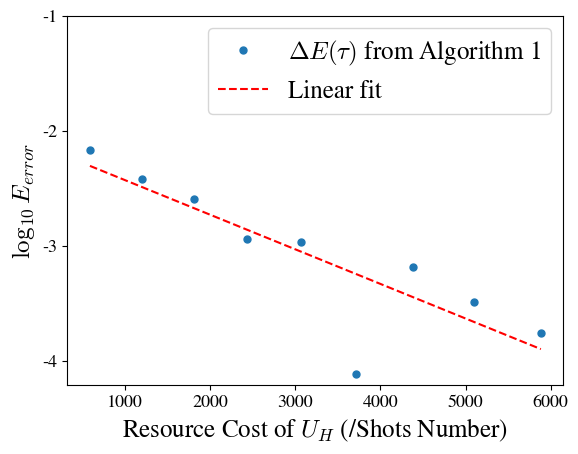

In [20]:
plt.plot(List_resource, List_E_tau_log, 'o', label=r'$\Delta E(\tau)$ from Algorithm 1', markersize=5, color='C0')
plt.plot(x_fit, y_fit, '--', label=f'Linear fit', color='red')

plt.xlabel(r'Resource Cost of $U_H$ (/Shots Number)', fontsize=fontsize)
plt.ylabel(r'$\log_{10}E_{error}$', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)
yticks2 = np.linspace(-1, -4.00, 4)
plt.yticks(yticks2, [f'{tick:.0f}' for tick in yticks2])
plt.tick_params(labelsize=13)

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

plt.show()

In [21]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.3.1+cu121
torch cuda: 12.1
numpy: 1.26.3
scipy: 1.14.0
matplotlib: 3.9.0
---------SYSTEM---------
Python version: 3.10.14
OS: Linux
OS version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
---------DEVICE---------
CPU:  13th Gen Intel(R) Core(TM) i9-13980HX
GPU: (0) NVIDIA GeForce RTX 4090 Laptop GPU
